# **케라스와 텐서플로우(미니배치 경사하강법을 이용한 학습)**

### **1. 저수준 선형 분류 신경망 구현**

__도전 과제__: 

1. 위 코드는 배치 경사하강법을 사용한다. 이제 미니 배치 경사하강법이 작동하도록 하라. 
    배치 크기는 100으로 한다.
1. `metrics`로 예측 정확도를 훈련 과정 중에 측정하는 기능을 추가하라. 
1. 세 개의 층을 사용하는 모델을 구현하라. 

순수 텐서플로우 API만을 이용하여 두 개의 층을 갖는 선형 분류 신경망을 구현하라.

In [ ]:
import tensorflow as tf
import numpy as np

#### **1.1. 데이터셋 생성**

- `np.random.multivariate_normal()`
    - 다변량 정규분포를 따르는 데이터 생성
    - 평균값과 공분산 지정 필요
- 음성 데이터셋
    - 샘플 수: 1,000
    - 평균값: `[0, 3]`
    - 공분산: `[[1, 0.5],[0.5, 1]]`
- 양성 데이터셋
    - 샘플 수: 1,000
    - 평균값: `[3, 0]`
    - 공분산: `[[1, 0.5],[0.5, 1]]`

In [ ]:
num_samples_per_class = 1000

# 음성 데이터셋
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

# 양성 데이터셋
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

두 개의 `(1000, 2)` 모양의 양성, 음성 데이터셋을 하나의 `(2000, 2)` 모양의 데이터셋으로 합치면서
동시에 자료형을 `np.float32`로 지정한다. 
자료형을 지정하지 않으면 `np.float64`로 지정되어 보다 많은 메모리와 실행시간을 요구한다.

In [ ]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

음성 샘플의 타깃은 0, 양성 샘플의 타깃은 1로 지정한다.

In [ ]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

양성, 음성 샘플을 색깔로 구분하면 다음과 같다.

- `inputs[:, 0]`: x 좌표
- `inputs[:, 1]`: x 좌표
- `c=targets[:, 0]`: 0 또는 1에 따른 색상 지정

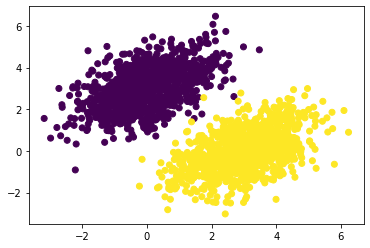

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

### **1.5. 들어가기 앞서**

---

**배치 경사 하강법(Batch Gradient Descent)**은 가장 기본적인 경사 하강법이다.

```
model.fit(X_train, y_train, batch_size=len(train_X))
```

**미니 배치 경사 하강법(Mini-Batch Gradient Descent)**

전체 데이터도 아니고, 1개의 데이터도 아니고 정해진 양에 대해서만 계산하여 매개 변수의 값을 조정하는 경사 하강법을 미니 배치 경사 하강법이라고 한다.

미니 배치 경사 하강법은 전체 데이터를 계산하는 것보다 빠르며, SGD(확률적)보다 안정적이라는 장점이 있다.
```
model.fit(X_train, y_train, batch_size=32) #32를 배치 크기로 하였을 경우
```

물론 머신러닝을 공부할 때 학습한 내용이지만, 기억이 잘 안나서 다시 보았을 때 생각날 수 있을 수준으로 내용을 가져왔다.

우선, 위 내용은 배치 경사 하강법과 차이점을 알기 위해서 설명을 제외하고 가져온 내용이다.

데이터셋 생성까지 마친 지금 단계에서 파이썬 라이브러리인 **케라스(Keras)**를 사용하여 미니배치 경사하강법을 활용해보자.

---

### **2. `Dense` 클래스 구현 (layer 생성)**

우선 도전 과제 중 **세 번째 과제**인
 - **세 개의 층을 사용하는 모델을 구현하라.**
 
를 충족하기 위해 `Keras`의 `Dense layer`를 사용하려고 한다.

레이어에 대해 간단하게 설명하자면 입 출력을 연결해주고 가중치를 포함하고 있다.

`reLU`와 `softmax`의 특징과 차이는 밑의 내용과 같다.

---

**렐루(ReLU)**

 - 입력이 양수일 때 x, 음수일 때 0 출력
 - 경사하강에 영향 X -> 다른 활성화 함수에 비해 학습이 빠름
 - 보통 Hidden Layer에 사용
 - 음수 값을 입력 받으면 항상 0이기 때문에 훈련 능력 감소

**소프트맥스(Softmax)**

 - 입력받은 값을 0~1 사이의 출력으로 정규화하여 출력 값들의 총합이 항상 1
 - 출력 노드의 활성화 함수로 많이 사용

**시그모이드(Sigmoid)**

 - 선형함수의 결과를 0~1까지의 비선형 형태로 변형

---

모델은 3개의 `Dense layer`으로 구성하였다.

32, 64, 10개의 특성을 갖는 출력 값을 계산한 후 다음 층으로 전달하게 하도록 만들어 보자.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(  [
        layers.Dense(32, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="sigmoid"),
])

In [ ]:
# 레이어 확인
model.layers

---

### **3. 모델 컴파일**

모델의 구조를 정의하고 아래 세 가지 설정을 추가로 지정해야 한다.

- 옵티마이저(optimizer): 모델의 성능을 향상시키는 방향으로 가중치를 업데이트하는 알고리즘
- 손실함수(loss function): 훈련 중 모델의 성능 얼마 나쁜가를 측정하는 기준. 
    - 미분가능이어야 하며 옵티마이저가 경사하강법을 활용하여 손실함숫값을 줄이는 방향으로 작동함.
- 평가지표(metrics): 훈련과 테스트 과정을 모니터링 할 때 사용되는 모델 평가 지표. 
    - 옵티마이저 또는 손실함수와 일반적으로 상관 없음.

여기서 평가지표(metrics)를 추가하기 때문에 **두번째 과제**인
 - **`metrics`로 예측 정확도를 훈련 과정 중에 측정하는 기능을 추가하라.**
 
 도 만족하기 위해서 추가한다.

값을 계산하기 위해`RMSE`와 `R2`를 계산해서 가져온다.

In [ ]:
# rmse 값 계산
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
model.compile(optimizer="rmsprop",
              loss=root_mean_squared_error,
              metrics=["binary_accuracy"])

---

### **4. `fit()` 메서드**

모델을 훈련시키려면 `fit()` 메서드를 적절한 인자들과 함께 호출해야 한다.

- 훈련 세트: 아까 준비한 `inputs`과 `targets`을 가져 온다.
- 에포크(`epochs`): 예제에서는 100번 훈련을 했으니 여기서도 동일.
- 배치 크기(`batch_size`): 배치 크기를 지정해주어 미니배치 경사하강법을 충족

아래 코드는 앞서 넘파이 어레이로 생성한 (2000, 2) 모양의 양성, 음성 데이터셋을 대상으로 훈련한다.

그리고 **첫 번째 과제**인 
 - **위 코드는 배치 경사하강법을 사용한다. 이제 미니 배치 경사하강법이 작동하도록 하라.**

 도 충족시킨다. 참고로 배치 크기는 조건인 100으로 지정하였다.

**두 번째 과제**인 
  - **`metrics`로 예측 정확도를 훈련 과정 중에 측정하는 기능을 추가하라.**

보다시피 훈련 과정에서 `metrics`를 `accuracy`로 표시하는 것을 확인할 수 있다.

In [ ]:
history = model.fit(
    inputs,
    targets,
    epochs=100,
    batch_size=100
)

Epoch 1/100
20/20 [==============================] - 1s 1ms/step - loss: 0.4480 - binary_accuracy: 0.7187
Epoch 2/100
20/20 [==============================] - 0s 1ms/step - loss: 0.2993 - binary_accuracy: 0.9829
Epoch 3/100
20/20 [==============================] - 0s 1ms/step - loss: 0.1671 - binary_accuracy: 0.9973
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0905 - binary_accuracy: 0.9982
Epoch 5/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0543 - binary_accuracy: 0.9983
Epoch 6/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0380 - binary_accuracy: 0.9985
Epoch 7/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0305 - binary_accuracy: 0.9985
Epoch 8/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0272 - binary_accuracy: 0.9980
Epoch 9/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0242 - binary_accuracy: 0.9985
Epoch 10/100
20/20 [==========================

훈련이 종료되면 `fit()` 메서드는 `History` 객체를 반환하며,
`history` 속성에 훈련 과정 중에 측정된 손실값, 평가지표를 에포크 단위로 기억한다.

In [ ]:
history.history

{'binary_accuracy': [0.7186500430107117,
  0.9829002022743225,
  0.9972999691963196,
  0.9981500506401062,
  0.9982500672340393,
  0.9984999895095825,
  0.9984999895095825,
  0.9980000257492065,
  0.9984999895095825,
  0.9979000091552734,
  0.998199999332428,
  0.9984000325202942,
  0.9984999895095825,
  0.9980000257492065,
  0.9984999895095825,
  0.9980000257492065,
  0.9980000257492065,
  0.9980000257492065,
  0.9989500045776367,
  0.9984999895095825,
  0.9990000128746033,
  0.9980000257492065,
  0.9980000257492065,
  0.9989500045776367,
  0.9980000257492065,
  0.9980000257492065,
  0.9984999895095825,
  0.9984999895095825,
  0.9984999895095825,
  0.9984999895095825,
  0.9984999895095825,
  0.9980000257492065,
  0.9990000128746033,
  0.9984000325202942,
  0.9980000257492065,
  0.9984999895095825,
  0.9984999895095825,
  0.9985499978065491,
  0.9980000257492065,
  0.9980000257492065,
  0.9990000128746033,
  0.9984999895095825,
  0.9984999895095825,
  0.9984999895095825,
  0.9980000257

### **5. 예측**

__도전 과제__: 

1. 위 코드는 배치 경사하강법을 사용한다. 이제 미니 배치 경사하강법이 작동하도록 하라. 
    배치 크기는 100으로 한다.
1. `metrics`로 예측 정확도를 훈련 과정 중에 측정하는 기능을 추가하라. 
1. 세 개의 층을 사용하는 모델을 구현하라. 

세 가지 도전 과제를 충족한 예측 결과를 그래프로 확인하면 다음과 같다.

In [ ]:
predictions = model.predict(inputs)

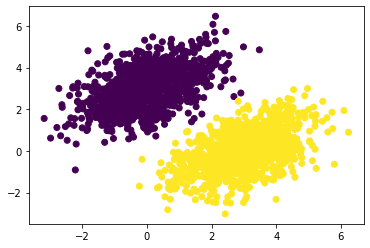

In [ ]:
# predictions 예측 결과
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

그리고 밑은 예측 결과가 아닌 처음에 `inputs`과 `targets`을 그래프로 그린 것이다.

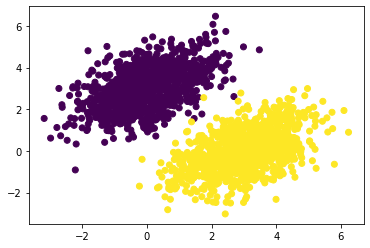

In [ ]:
# 맨 위의 샘플 구성 그래프
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

위의 그래프와 비교했을 때, 확실히 겹치는 부분이 사라진 것을 확인할 수 있었다.